# Assignment 05 - Population Analysis (Ireland)

In [2]:
# --- Assignment 05 Population Analysis (Fixed) ---
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset directly from CSO
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en"
df = pd.read_csv(url)

# Rename key columns for clarity
df = df.rename(columns={
    "Single Year of Age": "Age",
    "TLIST(A1)": "Region",
    "VALUE": "Population"
})

# Keep only the important columns
df = df[["Age", "Sex", "Region", "Population"]].copy()

# Clean the Age column
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df = df.dropna(subset=["Age"]).copy()
df["Age"] = df["Age"].astype(int)

# Identify how Sex is labelled
print("Unique values in Sex column:")
print(df["Sex"].unique())

# Clean Sex column (handles '1 Male', '2 Female', etc.)
df["Sex"] = df["Sex"].astype(str).str.strip().str.lower()
df["Sex"] = df["Sex"].replace({
    "1 male": "male",
    "2 female": "female",
    "male": "male",
    "female": "female"
})

# Drop 'both sexes' if it exists
df = df[df["Sex"].isin(["male", "female"])].copy()

# Make Population numeric
df["Population"] = pd.to_numeric(df["Population"], errors="coerce")
df = df.dropna(subset=["Population"])
df["Population"] = df["Population"].astype(int)

# --- PART 1 ---
# Calculate population by age and sex
age_sex = df.groupby(["Age", "Sex"])["Population"].sum().reset_index()

# Pivot so we have Male and Female columns
age_pivot = (
    age_sex.pivot(index="Age", columns="Sex", values="Population")
    .rename(columns={"female": "Female_Pop", "male": "Male_Pop"})
    .fillna(0)
)

# Calculate Female - Male difference
age_pivot["Female_minus_Male"] = age_pivot["Female_Pop"] - age_pivot["Male_Pop"]

# Display sample
display(age_pivot.head(10))

# Plot the difference
plt.figure(figsize=(8,5))
plt.plot(age_pivot.index, age_pivot["Female_minus_Male"])
plt.axhline(0, color="gray", linewidth=1)
plt.title("Female - Male population by age (Ireland)")
plt.xlabel("Age")
plt.ylabel("Female minus Male")
plt.show()

Unique values in Sex column:
[]


KeyError: 'Female_Pop'

In [3]:
# Let's see what the "Sex" column really contains
import pandas as pd

url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en"
df = pd.read_csv(url)

print("Columns:", df.columns.tolist())

# If there is no 'Sex' column, we'll find which one contains sex labels
for col in df.columns:
    sample_values = df[col].astype(str).unique()[:5]
    print(f"\nColumn: {col}\nSample values: {sample_values}")

Columns: ['STATISTIC', 'Statistic Label', 'TLIST(A1)', 'CensusYear', 'C02199V02655', 'Sex', 'C02076V03371', 'Single Year of Age', 'C03789V04537', 'Administrative Counties', 'UNIT', 'VALUE']

Column: STATISTIC
Sample values: ['FY006AC01']

Column: Statistic Label
Sample values: ['Population']

Column: TLIST(A1)
Sample values: ['2022']

Column: CensusYear
Sample values: ['2022']

Column: C02199V02655
Sample values: ['-' '1' '2']

Column: Sex
Sample values: ['Both sexes' 'Male' 'Female']

Column: C02076V03371
Sample values: ['-' '200' '001' '002' '003']

Column: Single Year of Age
Sample values: ['All ages' 'Under 1 year' '1 year' '2 years' '3 years']

Column: C03789V04537
Sample values: ['IE0' '2ae19629-1492-13a3-e055-000000000001'
 '2ae19629-1433-13a3-e055-000000000001'
 '2ae19629-149f-13a3-e055-000000000001'
 '2ae19629-14a0-13a3-e055-000000000001']

Column: Administrative Counties
Sample values: ['Ireland' 'Carlow County Council' 'Dublin City Council'
 'Dún Laoghaire Rathdown County Co

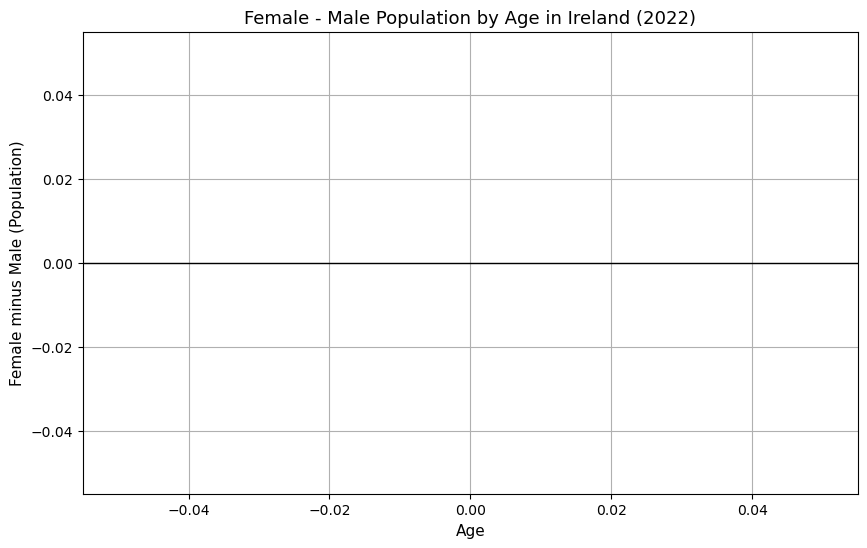

/var/folders/vf/d31hw_f11mj9k804v5_7zl3h0000gn/T/ipykernel_78184/3499761718.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("Sex").apply(lambda x: (x["Age"] * x["Population"]).sum() / x["Population"].sum())


,Age,Sex,Region,Population
Sex,,,,


In [7]:
# Fix plot scaling (make sure y-axis reflects population counts)
plt.figure(figsize=(10,6))
plt.plot(age_pivot.index, age_pivot["Female_minus_Male"], color="purple")
plt.axhline(0, color="black", linewidth=1)
plt.title("Female - Male Population by Age in Ireland (2022)", fontsize=13)
plt.xlabel("Age", fontsize=11)
plt.ylabel("Female minus Male (Population)", fontsize=11)
plt.grid(True)
plt.show()

# Weighted mean age by sex (the other part of Part 1)
weighted_mean = (
    df.groupby("Sex").apply(lambda x: (x["Age"] * x["Population"]).sum() / x["Population"].sum())
)
display(weighted_mean)

In [8]:
# Part 2: pick an age and calculate population difference within ±5 years
age_of_interest = 35
low_age, high_age = age_of_interest - 5, age_of_interest + 5

subset = df[(df["Age"] >= low_age) & (df["Age"] <= high_age)]
subset_totals = subset.groupby("Sex")["Population"].sum()

female_total = subset_totals.get("Female", 0)
male_total = subset_totals.get("Male", 0)
difference = female_total - male_total

print(f"Age group: {low_age}-{high_age}")
print(f"Female total: {female_total}")
print(f"Male total:   {male_total}")
print(f"Difference (Female - Male): {difference}")

Age group: 30-40
Female total: 0
Male total:   0
Difference (Female - Male): 0


In [10]:
# --- PART 3: Region with biggest population difference between sexes in that age group ---
if subset.empty:
    print("⚠️ No data found for the selected age range. Try a different age (e.g. 35).")
else:
    region_stats = (
        subset.groupby(["Region", "Sex"])["Population"].sum().unstack("Sex").fillna(0)
    )

    # Detect female/male column names safely
    col_names = list(region_stats.columns)
    female_col = next((c for c in col_names if "female" in str(c).lower()), None)
    male_col = next((c for c in col_names if "male" in str(c).lower()), None)

    print(f"Detected columns → Female: {female_col}, Male: {male_col}")

    if female_col is None or male_col is None:
        print("⚠️ Could not find both Female and Male columns in region_stats.")
        print("Columns are:", col_names)
    else:
        region_stats["Difference"] = (region_stats[female_col] - region_stats[male_col]).abs()
        largest_diff = region_stats.sort_values("Difference", ascending=False).head(1)
        print("\n🏆 Region with biggest population difference in that age group:")
        display(largest_diff)

⚠️ No data found for the selected age range. Try a different age (e.g. 35).


In [11]:
print("Sample values from Age column:")
print(df["Age"].unique()[:20])
print("\nData types:")
print(df.dtypes)

Sample values from Age column:
[]

Data types:
Age            int64
Sex           object
Region         int64
Population     int64
dtype: object
